# Regression Models

Train regression models to predict citation counts (log-transformed):
1. Load features and targets
2. Train baseline models
3. 5-fold cross-validation
4. Evaluate on temporal test set
5. Save best models

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from pathlib import Path
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline

## 1. Load Data

In [2]:
feature_dir = Path('../data/features')

X_train = pd.read_pickle(feature_dir / 'X_train_temporal.pkl')
X_test = pd.read_pickle(feature_dir / 'X_test_temporal.pkl')
y_train = pd.read_pickle(feature_dir / 'y_train_reg_temporal.pkl')
y_test = pd.read_pickle(feature_dir / 'y_test_reg_temporal.pkl')

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"\nTarget (log-transformed citations):")
print(f"Train range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"Test range: {y_test.min():.2f} - {y_test.max():.2f}")

Train: (2545, 5019)
Test: (3573, 5019)

Target (log-transformed citations):
Train range: 0.00 - 8.73
Test range: 0.00 - 10.17


## 2. Define Models

In [3]:
models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

print("Models defined:")
for name in models.keys():
    print(f"  - {name}")

Models defined:
  - Linear Regression
  - Random Forest
  - XGBoost
  - LightGBM


## 3. Define Custom Scorer for Spearman Correlation

In [4]:
from sklearn.metrics import make_scorer

def spearman_scorer(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

spearman_score = make_scorer(spearman_scorer)

## 4. Train and Evaluate with Cross-Validation

In [5]:
cv_results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
    'spearman': spearman_score
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {
        'mse': -scores['test_mse'].mean(),
        'rmse': np.sqrt(-scores['test_mse'].mean()),
        'mae': -scores['test_mae'].mean(),
        'r2': scores['test_r2'].mean(),
        'spearman': scores['test_spearman'].mean()
    }
    
    print(f"  RMSE: {cv_results[name]['rmse']:.4f}")
    print(f"  MAE: {cv_results[name]['mae']:.4f}")
    print(f"  R²: {cv_results[name]['r2']:.4f}")
    print(f"  Spearman: {cv_results[name]['spearman']:.4f}")

cv_df = pd.DataFrame(cv_results).T
print("\nCross-validation results:")
print(cv_df)


Training Linear Regression...
  RMSE: 1.7342
  MAE: 1.3330
  R²: -0.8610
  Spearman: 0.3596

Training Random Forest...
  RMSE: 0.9896
  MAE: 0.7756
  R²: 0.3982
  Spearman: 0.6002

Training XGBoost...
  RMSE: 0.9915
  MAE: 0.7819
  R²: 0.3955
  Spearman: 0.5989

Training LightGBM...
  RMSE: 0.9902
  MAE: 0.7748
  R²: 0.3973
  Spearman: 0.5995

Cross-validation results:
                        mse      rmse       mae        r2  spearman
Linear Regression  3.007530  1.734223  1.332987 -0.860981  0.359629
Random Forest      0.979302  0.989597  0.775616  0.398186  0.600246
XGBoost            0.983153  0.991541  0.781865  0.395543  0.598891
LightGBM           0.980476  0.990190  0.774756  0.397298  0.599528


## 5. Train on Full Training Set and Evaluate on Test Set

In [6]:
test_results = {}
trained_models = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name} on full training set...")
    
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    test_results[name] = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'spearman': spearmanr(y_test, y_pred)[0]
    }
    
    print(f"Test Set Performance:")
    print(f"  RMSE: {test_results[name]['rmse']:.4f}")
    print(f"  MAE: {test_results[name]['mae']:.4f}")
    print(f"  R²: {test_results[name]['r2']:.4f}")
    print(f"  Spearman: {test_results[name]['spearman']:.4f}")

test_df = pd.DataFrame(test_results).T
print("\nTest set results:")
print(test_df)


Training Linear Regression on full training set...
Test Set Performance:
  RMSE: 2.0668
  MAE: 1.5918
  R²: -1.8405
  Spearman: 0.2733

Training Random Forest on full training set...
Test Set Performance:
  RMSE: 0.9907
  MAE: 0.7726
  R²: 0.3474
  Spearman: 0.5768

Training XGBoost on full training set...
Test Set Performance:
  RMSE: 0.9994
  MAE: 0.7822
  R²: 0.3359
  Spearman: 0.5770

Training LightGBM on full training set...
Test Set Performance:
  RMSE: 0.9949
  MAE: 0.7783
  R²: 0.3419
  Spearman: 0.5810

Test set results:
                        mse      rmse       mae        r2  spearman
Linear Regression  4.271813  2.066836  1.591850 -1.840474  0.273333
Random Forest      0.981501  0.990707  0.772630  0.347366  0.576770
XGBoost            0.998789  0.999394  0.782202  0.335871  0.576983
LightGBM           0.989759  0.994867  0.778299  0.341875  0.580986


## 6. Compare Models

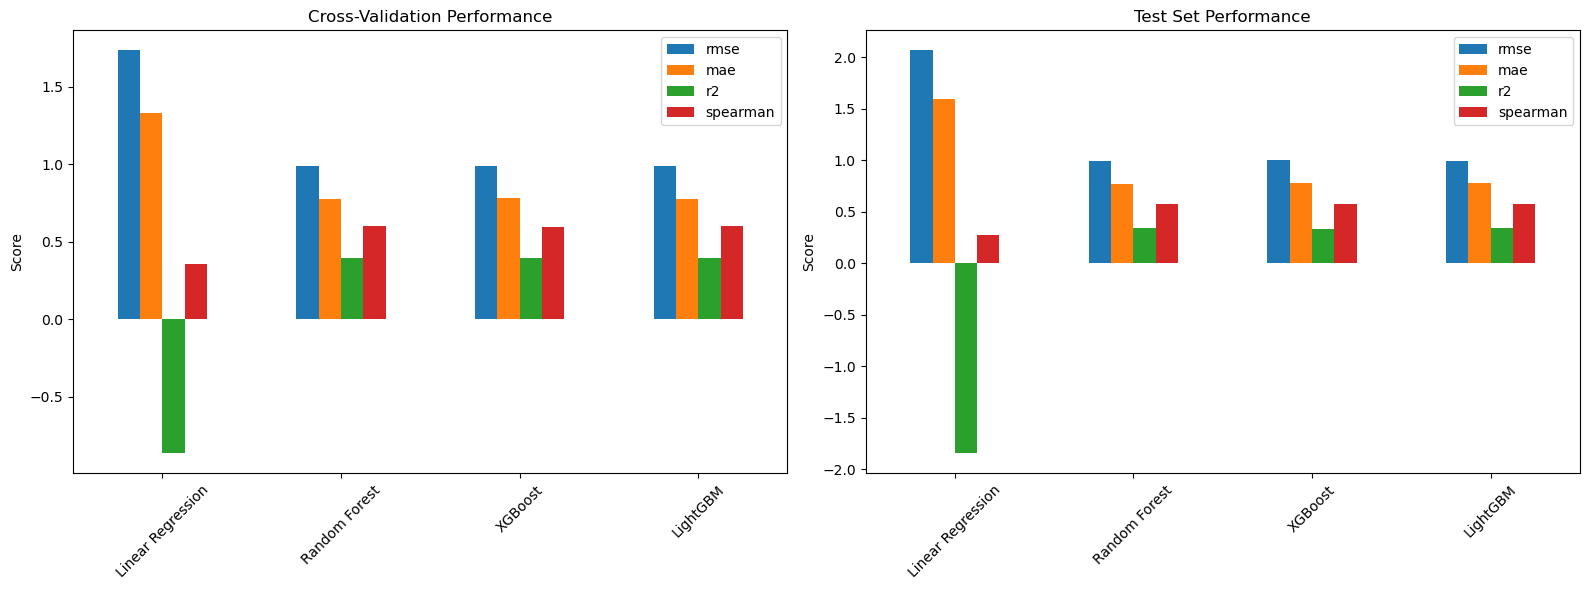

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cv_df[['rmse', 'mae', 'r2', 'spearman']].plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Cross-Validation Performance')
axes[0].set_ylabel('Score')
axes[0].legend(loc='upper right')

test_df[['rmse', 'mae', 'r2', 'spearman']].plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Test Set Performance')
axes[1].set_ylabel('Score')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 7. Prediction vs Actual Plots

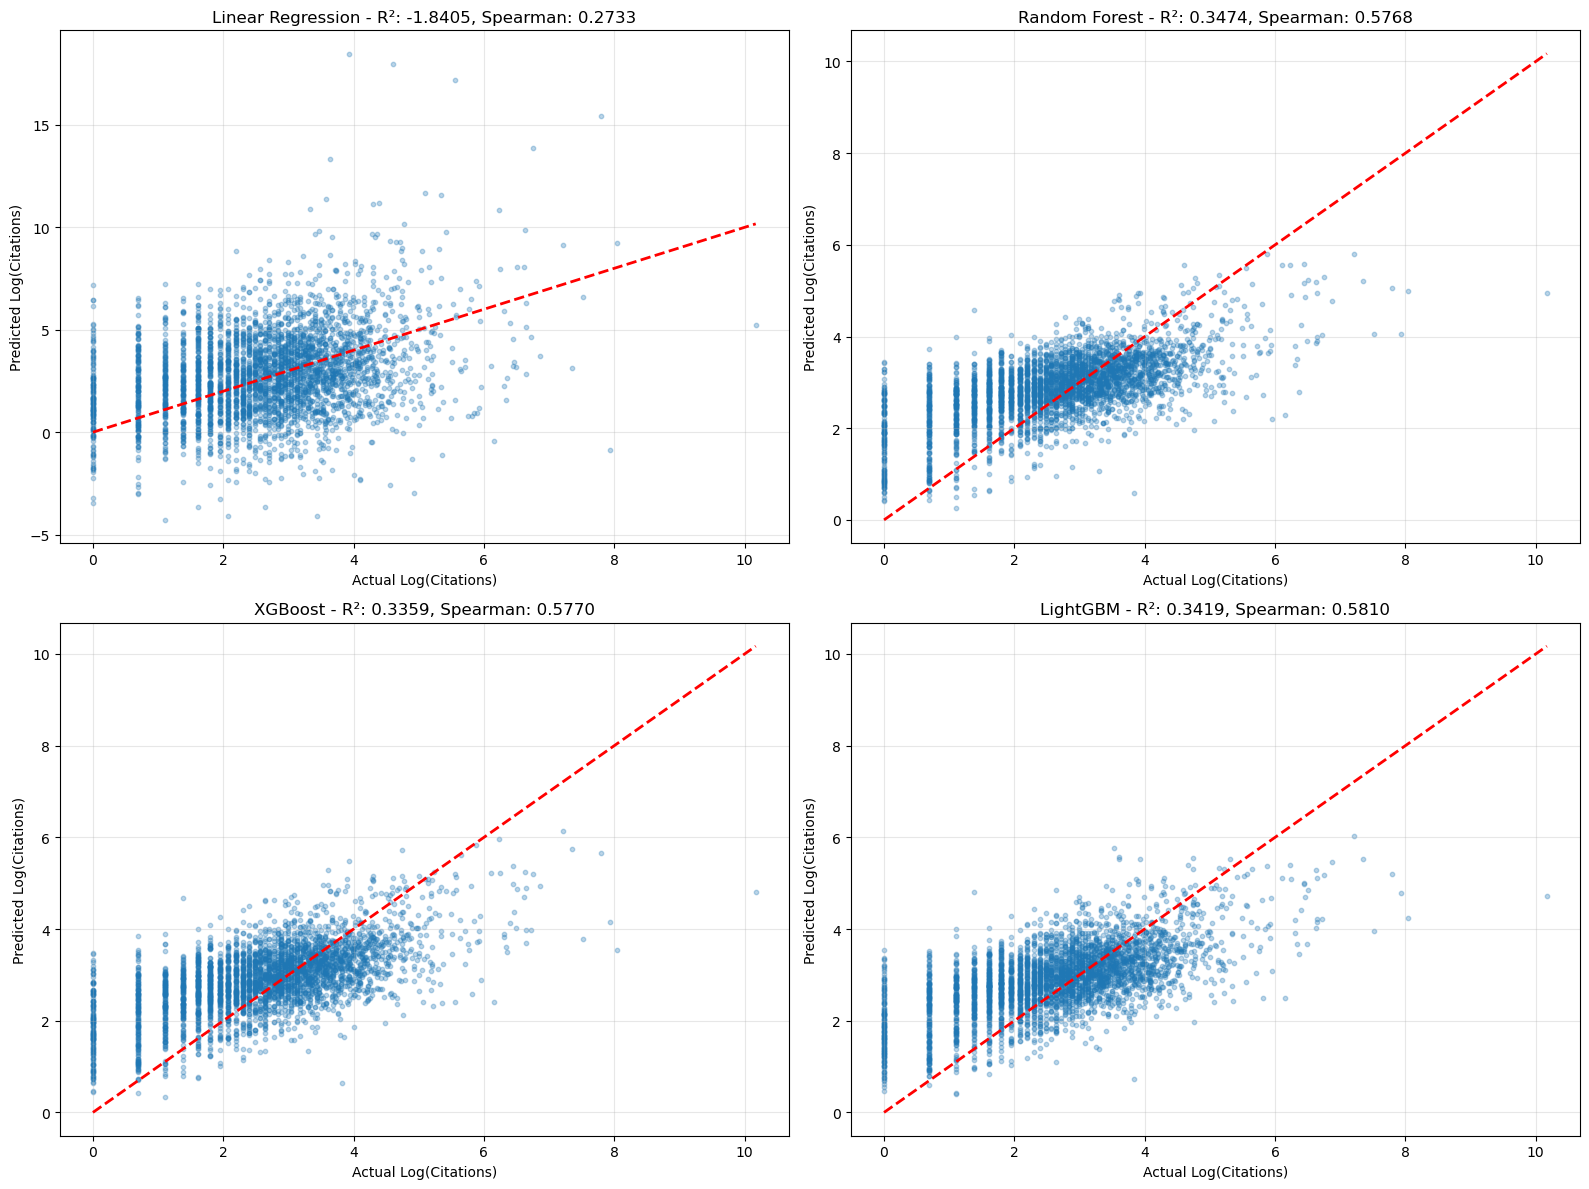

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=10)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Log(Citations)')
    axes[idx].set_ylabel('Predicted Log(Citations)')
    axes[idx].set_title(f'{name} - R²: {test_results[name]["r2"]:.4f}, Spearman: {test_results[name]["spearman"]:.4f}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Models

In [9]:
model_dir = Path('../models/regression')
model_dir.mkdir(parents=True, exist_ok=True)

for name, model in trained_models.items():
    filename = name.lower().replace(' ', '_') + '.pkl'
    with open(model_dir / filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

results_df = pd.DataFrame({
    'CV_RMSE': cv_df['rmse'],
    'CV_R2': cv_df['r2'],
    'CV_Spearman': cv_df['spearman'],
    'Test_RMSE': test_df['rmse'],
    'Test_R2': test_df['r2'],
    'Test_Spearman': test_df['spearman']
})
results_df.to_csv('../reports/metrics/regression_results.csv')
print(f"\nResults saved to reports/metrics/regression_results.csv")

Saved: linear_regression.pkl
Saved: random_forest.pkl
Saved: xgboost.pkl
Saved: lightgbm.pkl

Results saved to reports/metrics/regression_results.csv


## Summary

In [10]:
print("=" * 60)
print("REGRESSION MODELS SUMMARY")
print("=" * 60)
print(f"\nBest CV R²: {cv_df['r2'].idxmax()} ({cv_df['r2'].max():.4f})")
print(f"Best CV Spearman: {cv_df['spearman'].idxmax()} ({cv_df['spearman'].max():.4f})")
print(f"\nBest Test R²: {test_df['r2'].idxmax()} ({test_df['r2'].max():.4f})")
print(f"Best Test Spearman: {test_df['spearman'].idxmax()} ({test_df['spearman'].max():.4f})")
print(f"\nNote: Predictions are on log-transformed citation counts")

REGRESSION MODELS SUMMARY

Best CV R²: Random Forest (0.3982)
Best CV Spearman: Random Forest (0.6002)

Best Test R²: Random Forest (0.3474)
Best Test Spearman: LightGBM (0.5810)

Note: Predictions are on log-transformed citation counts
